Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CastleGate volume shape: (1000, 1000, 1000) (1000, 1000, 1000)
Bentheimer volume shape: (1000, 1000, 1000) (1000, 1000, 1000)


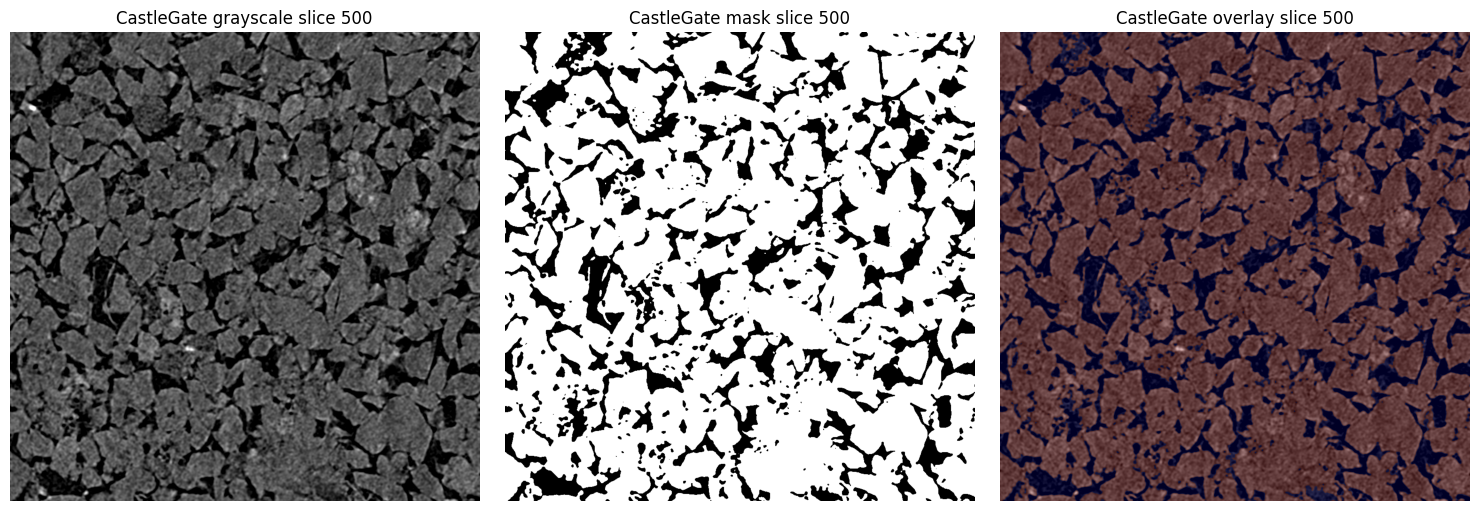

Selected indices (per volume): [  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850
 900 950] len: 20
CastleGate train indices: [  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750]
CastleGate val indices: [800 850 900 950]
Bentheimer train indices: [  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750]
Bentheimer val indices: [800 850 900 950]
Train dataset size (total slices): 32
Val dataset size (total slices): 8
UNet (32-64-128-256-512) defined.
Using device: cuda
Training for 20 epochs on CastleGate + Bentheimer slices...
* Epoch 01/20 - Train Loss: 0.1757 - Val Loss: 0.2516
* Epoch 02/20 - Train Loss: 0.1181 - Val Loss: 0.1635
* Epoch 03/20 - Train Loss: 0.0931 - Val Loss: 0.0967
* Epoch 04/20 - Train Loss: 0.0741 - Val Loss: 0.0732
* Epoch 05/20 - Train Loss: 0.0601 - Val Loss: 0.0562
* Epoch 06/20 - Train Loss: 0.0497 - Val Loss: 0.0473
* Epoch 07/20 - Train Loss: 0.0418 - Val Loss: 0.0386
* Epoch 08/20 - Train Loss: 0.0356 - Val Loss:

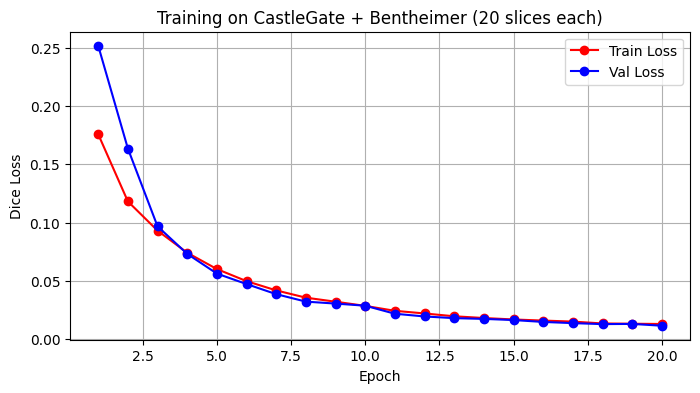

Pretrained UNet weights saved to: /content/drive/MyDrive/unet_castlegate_bentheimer_20slices_pretrained.pth


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# 1. Paths and memmap volumes
# -----------------------------
# CastleGate
path_img_cg = "/content/drive/MyDrive/CastleGate_2d25um_grayscale.raw"
path_msk_cg = "/content/drive/MyDrive/CastleGate_2d25um_binary.raw"

# Bentheimer
path_img_bh = "/content/drive/MyDrive/Bentheimer_2d25um_grayscale.raw"
path_msk_bh = "/content/drive/MyDrive/Bentheimer_2d25um_binary.raw"

# Volume dimensions
D, H, W = 1000, 1000, 1000  # depth, height, width

# Memmap volumes (do not load all into RAM)
volume_img_cg = np.memmap(path_img_cg, dtype=np.uint8, mode='r', shape=(D, H, W))
volume_msk_cg = np.memmap(path_msk_cg, dtype=np.uint8, mode='r', shape=(D, H, W))

volume_img_bh = np.memmap(path_img_bh, dtype=np.uint8, mode='r', shape=(D, H, W))
volume_msk_bh = np.memmap(path_msk_bh, dtype=np.uint8, mode='r', shape=(D, H, W))

print("CastleGate volume shape:", volume_img_cg.shape, volume_msk_cg.shape)
print("Bentheimer volume shape:", volume_img_bh.shape, volume_msk_bh.shape)

# -----------------------------
# 2. Quick visualization (optional)
# -----------------------------
slice_idx = 500  # can change
img_slice = volume_img_cg[slice_idx]
msk_slice = volume_msk_cg[slice_idx]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_slice, cmap="gray")
plt.title(f"CastleGate grayscale slice {slice_idx}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(msk_slice, cmap="gray")
plt.title(f"CastleGate mask slice {slice_idx}")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_slice, cmap="gray")
plt.imshow(msk_slice, cmap="jet", alpha=0.3)
plt.title(f"CastleGate overlay slice {slice_idx}")
plt.axis("off")
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Generic dataset for 2D slices
# -----------------------------
class Volume2DDataset(Dataset):
    def __init__(self, volume_img, volume_msk, indices):
        """
        volume_img: np.memmap or np.ndarray of shape (D, H, W)
        volume_msk: np.memmap or np.ndarray of shape (D, H, W)
        indices: list/array of slice indices to use
        """
        self.volume_img = volume_img
        self.volume_msk = volume_msk
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        slice_idx = self.indices[idx]

        # Load slices
        img_slice = self.volume_img[slice_idx].astype(np.float32) / 255.0  # [0,1]
        msk_slice = (self.volume_msk[slice_idx] > 0).astype(np.float32)    # 0/1

        # --- Center crop to make H and W multiples of 16 ---
        h, w = img_slice.shape
        new_h = h - (h % 16)  # e.g. 1000 -> 992
        new_w = w - (w % 16)  # e.g. 1000 -> 992

        top = (h - new_h) // 2
        left = (w - new_w) // 2

        img_slice = img_slice[top:top+new_h, left:left+new_w]
        msk_slice = msk_slice[top:top+new_h, left:left+new_w]
        # --- end crop ---

        # Add channel dimension: (1, H, W)
        img_tensor = torch.from_numpy(img_slice).unsqueeze(0)
        msk_tensor = torch.from_numpy(msk_slice).unsqueeze(0)

        return img_tensor, msk_tensor

# Use only 20 slices per volume, spaced every 50 slices: 0, 50, 100, ..., 950
all_selected_indices = np.arange(0, 1000, 50)  # length 20
print("Selected indices (per volume):", all_selected_indices, "len:", len(all_selected_indices))

# Simple split: first 16 for train, last 4 for val (per volume)
train_indices_cg = all_selected_indices[:16]
val_indices_cg   = all_selected_indices[16:]

train_indices_bh = all_selected_indices[:16]
val_indices_bh   = all_selected_indices[16:]

print("CastleGate train indices:", train_indices_cg)
print("CastleGate val indices:",   val_indices_cg)
print("Bentheimer train indices:", train_indices_bh)
print("Bentheimer val indices:",   val_indices_bh)

# Datasets for each volume
train_dataset_cg = Volume2DDataset(volume_img_cg, volume_msk_cg, train_indices_cg)
val_dataset_cg   = Volume2DDataset(volume_img_cg, volume_msk_cg, val_indices_cg)

train_dataset_bh = Volume2DDataset(volume_img_bh, volume_msk_bh, train_indices_bh)
val_dataset_bh   = Volume2DDataset(volume_img_bh, volume_msk_bh, val_indices_bh)

# Concatenate datasets (CastleGate + Bentheimer)
train_dataset = ConcatDataset([train_dataset_cg, train_dataset_bh])
val_dataset   = ConcatDataset([val_dataset_cg,   val_dataset_bh])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False)

print("Train dataset size (total slices):", len(train_dataset))
print("Val dataset size (total slices):",   len(val_dataset))

# -----------------------------
# 4. UNet architecture (32-64-128-256-512)
# -----------------------------
class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) * 2, stored in .net to match checkpoint keys"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    """
    U-Net with channel sizes:
      down1:  1   ->  32
      down2: 32   ->  64
      down3: 64   -> 128
      down4: 128  -> 256
      down5: 256  -> 512 (bottleneck)
    and symmetric decoder.
    """
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.down1 = DoubleConv(in_channels, 32)
        self.down2 = DoubleConv(32, 64)
        self.down3 = DoubleConv(64, 128)
        self.down4 = DoubleConv(128, 256)

        # Bottleneck
        self.down5 = DoubleConv(256, 512)

        # Decoder
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(32 + 32, 32)

        # Final 1x1 conv
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(F.max_pool2d(x1, 2))
        x3 = self.down3(F.max_pool2d(x2, 2))
        x4 = self.down4(F.max_pool2d(x3, 2))

        # Bottleneck
        x5 = self.down5(F.max_pool2d(x4, 2))

        # Decoder
        x = self.up4(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv4(x)

        x = self.up3(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv3(x)

        x = self.up2(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv2(x)

        x = self.up1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv1(x)

        x = self.final(x)
        return x

print("UNet (32-64-128-256-512) defined.")

# -----------------------------
# 5. Loss function (Dice) and training utilities
# -----------------------------
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        p = torch.sigmoid(y_pred)

        if p.dim() == 3:
            p = p.unsqueeze(1)
            y_true = y_true.unsqueeze(1)
        elif y_true.dim() == 3:
            y_true = y_true.unsqueeze(1)

        N = p.shape[0]
        p_f = p.contiguous().view(N, -1)
        y_f = y_true.contiguous().view(N, -1)
        smooth = 1.0
        intersection = (p_f * y_f).sum(dim=1)
        denom = p_f.sum(dim=1) + y_f.sum(dim=1)
        dice = (2.0 * intersection + smooth) / (denom + smooth)
        return (1.0 - dice).mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet(in_channels=1, out_channels=1).to(device)
loss_fn = DiceLoss()
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 50  # more data than before, 35 is reasonable
print("Training for", epochs, "epochs on CastleGate + Bentheimer slices...")

# -----------------------------
# 6. Training loop
# -----------------------------
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    # Training
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        opt.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        opt.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"* Epoch {epoch:02d}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

print("Pretraining on CastleGate + Bentheimer finished!")

# -----------------------------
# 7. Plot losses
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), train_losses, 'r-o', label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, 'b-o', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Dice Loss")
plt.title("Training on CastleGate + Bentheimer (20 slices each)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Save pretrained weights (state_dict)
# -----------------------------
pretrained_path = "/content/drive/MyDrive/unet_castlegate_bentheimer_20slices_pretrained.pth"
os.makedirs(os.path.dirname(pretrained_path), exist_ok=True)
torch.save(model.state_dict(), pretrained_path)
print(f"Pretrained UNet weights saved to: {pretrained_path}")


###TRYING ONLY WITH Bentheimer DATA

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# 1. Paths and memmap volumes (ONLY BENTHEIMER)
# -----------------------------
path_img_bh = "/content/drive/MyDrive/Bentheimer_2d25um_grayscale.raw"
path_msk_bh = "/content/drive/MyDrive/Bentheimer_2d25um_binary.raw"

# Volume dimensions
D, H, W = 1000, 1000, 1000  # depth, height, width

# Memmap volumes (do not load all into RAM)
volume_img_bh = np.memmap(path_img_bh, dtype=np.uint8, mode='r', shape=(D, H, W))
volume_msk_bh = np.memmap(path_msk_bh, dtype=np.uint8, mode='r', shape=(D, H, W))

print("Bentheimer volume shape:", volume_img_bh.shape, volume_msk_bh.shape)

# -----------------------------
# 2. Quick visualization (optional)
# -----------------------------
slice_idx = 500  # can change
img_slice = volume_img_bh[slice_idx]
msk_slice = volume_msk_bh[slice_idx]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_slice, cmap="gray")
plt.title(f"Bentheimer grayscale slice {slice_idx}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(msk_slice, cmap="gray")
plt.title(f"Bentheimer mask slice {slice_idx}")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_slice, cmap="gray")
plt.imshow(msk_slice, cmap="jet", alpha=0.3)
plt.title(f"Bentheimer overlay slice {slice_idx}")
plt.axis("off")
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Generic dataset for 2D slices
# -----------------------------
class Volume2DDataset(Dataset):
    def __init__(self, volume_img, volume_msk, indices):
        """
        volume_img: np.memmap or np.ndarray of shape (D, H, W)
        volume_msk: np.memmap or np.ndarray of shape (D, H, W)
        indices: list/array of slice indices to use
        """
        self.volume_img = volume_img
        self.volume_msk = volume_msk
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        slice_idx = self.indices[idx]

        # Load slices
        img_slice = self.volume_img[slice_idx].astype(np.float32) / 255.0  # [0,1]
        msk_slice = (self.volume_msk[slice_idx] > 0).astype(np.float32)    # 0/1

        # --- Center crop to make H and W multiples of 16 ---
        h, w = img_slice.shape
        new_h = h - (h % 16)  # e.g. 1000 -> 992
        new_w = w - (w % 16)  # e.g. 1000 -> 992

        top = (h - new_h) // 2
        left = (w - new_w) // 2

        img_slice = img_slice[top:top+new_h, left:left+new_w]
        msk_slice = msk_slice[top:top+new_h, left:left+new_w]
        # --- end crop ---

        # Add channel dimension: (1, H, W)
        img_tensor = torch.from_numpy(img_slice).unsqueeze(0)
        msk_tensor = torch.from_numpy(msk_slice).unsqueeze(0)

        return img_tensor, msk_tensor

# Use only 20 slices, spaced every 50 slices: 0, 50, 100, ..., 950
all_selected_indices = np.arange(0, 1000, 50)  # length 20
print("Selected indices (Bentheimer):", all_selected_indices, "len:", len(all_selected_indices))

# Simple split: first 16 for train, last 4 for val
train_indices_bh = all_selected_indices[:16]
val_indices_bh   = all_selected_indices[16:]

print("Bentheimer train indices:", train_indices_bh)
print("Bentheimer val indices:",   val_indices_bh)

# Datasets ONLY for Bentheimer
train_dataset = Volume2DDDataset(volume_img_bh, volume_msk_bh, train_indices_bh)
val_dataset   = Volume2DDDataset(volume_img_bh, volume_msk_bh, val_indices_bh)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False)

print("Train dataset size (Bentheimer):", len(train_dataset))
print("Val dataset size (Bentheimer):",   len(val_dataset))

# -----------------------------
# 4. UNet architecture (32-64-128-256-512)
# -----------------------------
class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) * 2, stored in .net to match checkpoint keys"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    """
    U-Net with channel sizes:
      down1:  1   ->  32
      down2: 32   ->  64
      down3: 64   -> 128
      down4: 128  -> 256
      down5: 256  -> 512 (bottleneck)
    and symmetric decoder.
    """
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.down1 = DoubleConv(in_channels, 32)
        self.down2 = DoubleConv(32, 64)
        self.down3 = DoubleConv(64, 128)
        self.down4 = DoubleConv(128, 256)

        # Bottleneck
        self.down5 = DoubleConv(256, 512)

        # Decoder
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(32 + 32, 32)

        # Final 1x1 conv
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(F.max_pool2d(x1, 2))
        x3 = self.down3(F.max_pool2d(x2, 2))
        x4 = self.down4(F.max_pool2d(x3, 2))

        # Bottleneck
        x5 = self.down5(F.max_pool2d(x4, 2))

        # Decoder
        x = self.up4(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv4(x)

        x = self.up3(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv3(x)

        x = self.up2(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv2(x)

        x = self.up1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv1(x)

        x = self.final(x)
        return x

print("UNet (32-64-128-256-512) defined.")

# -----------------------------
# 5. Loss function (Dice) and training utilities
# -----------------------------
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        p = torch.sigmoid(y_pred)

        if p.dim() == 3:
            p = p.unsqueeze(1)
            y_true = y_true.unsqueeze(1)
        elif y_true.dim() == 3:
            y_true = y_true.unsqueeze(1)

        N = p.shape[0]
        p_f = p.contiguous().view(N, -1)
        y_f = y_true.contiguous().view(N, -1)
        smooth = 1.0
        intersection = (p_f * y_f).sum(dim=1)
        denom = p_f.sum(dim=1) + y_f.sum(dim=1)
        dice = (2.0 * intersection + smooth) / (denom + smooth)
        return (1.0 - dice).mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet(in_channels=1, out_channels=1).to(device)
loss_fn = DiceLoss()
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 35  # for 20 slices Bentheimer, you can adjust
print("Training for", epochs, "epochs on Bentheimer slices...")

# -----------------------------
# 6. Training loop
# -----------------------------
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    # Training
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        opt.zero_grad()
        logits = model(X_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        opt.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = loss_fn(logits, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"* Epoch {epoch:02d}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

print("Pretraining on Bentheimer finished!")

# -----------------------------
# 7. Plot losses
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), train_losses, 'r-o', label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, 'b-o', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Dice Loss")
plt.title("Training on Bentheimer (20 slices)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 8. Save pretrained weights (state_dict)
# -----------------------------
pretrained_path = "/content/drive/MyDrive/unet_bentheimer_20slices_pretrained.pth"
os.makedirs(os.path.dirname(pretrained_path), exist_ok=True)
torch.save(model.state_dict(), pretrained_path)
print(f"Pretrained UNet weights saved to: {pretrained_path}")
